In [ ]:
## Theme - Social networks
# this code draws a graph ( 2 merged graphs) of the friends of both users, and prints intersections.
# Need to add own data loader in accordance with your network API
# only for scientifical purposes.

In [2]:
import numpy as np
import pandas as pd
import pickle
import time   
import matplotlib.pyplot as plt
from tqdm import tqdm # Progress Bar for Python and CLI 

import networkx as nx
# add yor API of the social network

In [3]:
# set exploring IDs
user1 = 4564533415122 # IDs example
user2 = 4564641546453

In [4]:
# Need to add own data loader in accordance with your network API
 
def get_groups_users(friends_list, tools): 
    friends_out = {} 
    for friend in tqdm(friends_list): 
        try: 
            friends_out[friend] = tools.get_all('friends.get', 100, {'user_id': friend}) 
        except Exception: 
            friends_out[friend] = [] 
        time.sleep(1) 
 
    return friends_out

In [8]:
# get friend of the target person
# tools is a object related with your network api
friend_list1=[] 
friend_list1.append(user1)

friends_out1 = get_groups_users(friend_list1, tools) 
print('Friends: ', friends_out1[user1]['count'])

friend_list2=[] 
friend_list2.append(user2)

friends_out2 = get_groups_users(friend_list2, tools) 
print('Friends: ', friends_out2[user2]['count'])
# structure of the friends_out: 
#{ID: {'count': int, 'items': [int,...]}}

  0%|          | 0/1 [00:00<?, ?it/s]

Friends:  120


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Friends:  175


In [10]:
# Let's get friend of friends
friends_friends1 = get_groups_users(friends_out1[user1]['items'], tools)
friends_friends2 = get_groups_users(friends_out2[user2]['items'], tools)

100%|██████████| 175/175 [03:12<00:00,  1.10s/it]


In [119]:
# SAVE

def save_friends_friends(obj_list):
    file_index = 1
    for friends_obj in obj_list:
        with open(f'friends_friends_{file_index}.pkl', 'wb') as output:
            pickle.dump(friends_obj, output, pickle.HIGHEST_PROTOCOL)
        file_index += 1    

save_friends_friends([friends_friends1,friends_friends2])


In [120]:
# OPEN

def read_friends_friends(obj_list):
    file_index = 1
    for friends_obj in obj_list:
        with open(f'friends_friends_{file_index}.pkl', 'rb') as input:
            friends_obj = pickle.load(input)
        file_index += 1    
    return obj_list

obj_list = read_friends_friends([friends_friends1,friends_friends2])     

In [17]:
# graph explorig algorithm 

def make_graph_full(friends_out, friends_friends, primary_user):
    graph = nx.Graph() 
    graph.add_node(primary_user, size = friends_out[primary_user]['count'])
    exception_count1:int = 0
    exception_count2:int = 0 
 
    for i in tqdm(friends_out[primary_user]['items']): 
        try: 
            graph.add_node(i, size = friends_friends[i]['count']) 
            intersection = set(friends_out[primary_user]['items']).intersection(set(friends_friends[i]['items'])) 
            graph.add_edge(primary_user, i, weight=len(intersection)) 
        except Exception:
            graph.add_node(i, size = 1) # modification
            graph.add_edge(primary_user, i, weight=1)
            exception_count1 +=1
 
    for i in tqdm(range(len(friends_out[primary_user]['items']))):
            id1= friends_out[primary_user]['items'][i]
            for k in range(i+1, len(friends_out[primary_user]['items'])): 
                id2= friends_out[primary_user]['items'][k] 
                try: 
                    intersection = set(friends_friends[id1]['items']).intersection(set(friends_friends[id2]['items'])) 
                    if len(intersection) > 0: 
                        graph.add_edge(id1, id2, weight=len(intersection)) 
                except Exception: 
                    exception_count2 +=1

    print("warning 1st : probably, this user can't give acces to own friends {} times", exception_count1)
    print("warning 2st : probably, this user can't give acces to own friends {} times", exception_count2)
    print("Result Nodes count in the graph:",len(graph.nodes))
    return graph

In [ ]:
g1 = make_graph_full(friends_out1, friends_friends1, user1)
g2 = make_graph_full(friends_out2, friends_friends2, user2)


In [85]:
# create united graph
u1= nx.compose(g1,g2)
#F has all nodes & edges of both graphs, including attributes
#Where the attributes conflict, it uses the attributes of H.

In [86]:
# print graph's intersections
ig1 = g1.copy()
ig1.remove_nodes_from(n for n in g1 if n not in g2)
ig1.remove_edges_from(e for e in g1.edges if e not in g2.edges)
ig1.nodes

NodeView((1612938558936,))

<span style="color:yellow">Graph Visualisation </span>

In [49]:
# plot with matplotlib (static variant)
def plot_graph(graph, adjust_nodesize:float, spring_k:float):
    #pos = nx.drawing.layout.circular_layout(graph) 
    pos=nx.spring_layout(graph, k=spring_k) 
    #normalize size 
    #adjust_nodesize ‐ от 300 до 500 
    nodesize = [graph. nodes[i]['size']/adjust_nodesize for i in graph.nodes()]   
    # Standard Score normalization
    edge_mean = np.mean([i[2] for i in graph.edges.data("weight")]) 
    edge_std_dev = np.std([i[2] for i in graph.edges.data("weight")]) 
    edgewidth = [((i[2] - edge_mean)/edge_std_dev/2) for i in graph.edges.data("weight")]
    #create visualisation graph
 
    nx.draw_networkx_nodes(graph, pos,node_size=nodesize, node_color='y', alpha=0.9) 
    nx.draw_networkx_edges(graph,pos,width=edgewidth,edge_color='b', alpha=0.3) 
    nx.draw_networkx_labels(graph,pos,font_size=5) 
    #show and save graph 
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['figure.figsize'] = [20, 20]
    plt.savefig('saved') 
    plt.show()

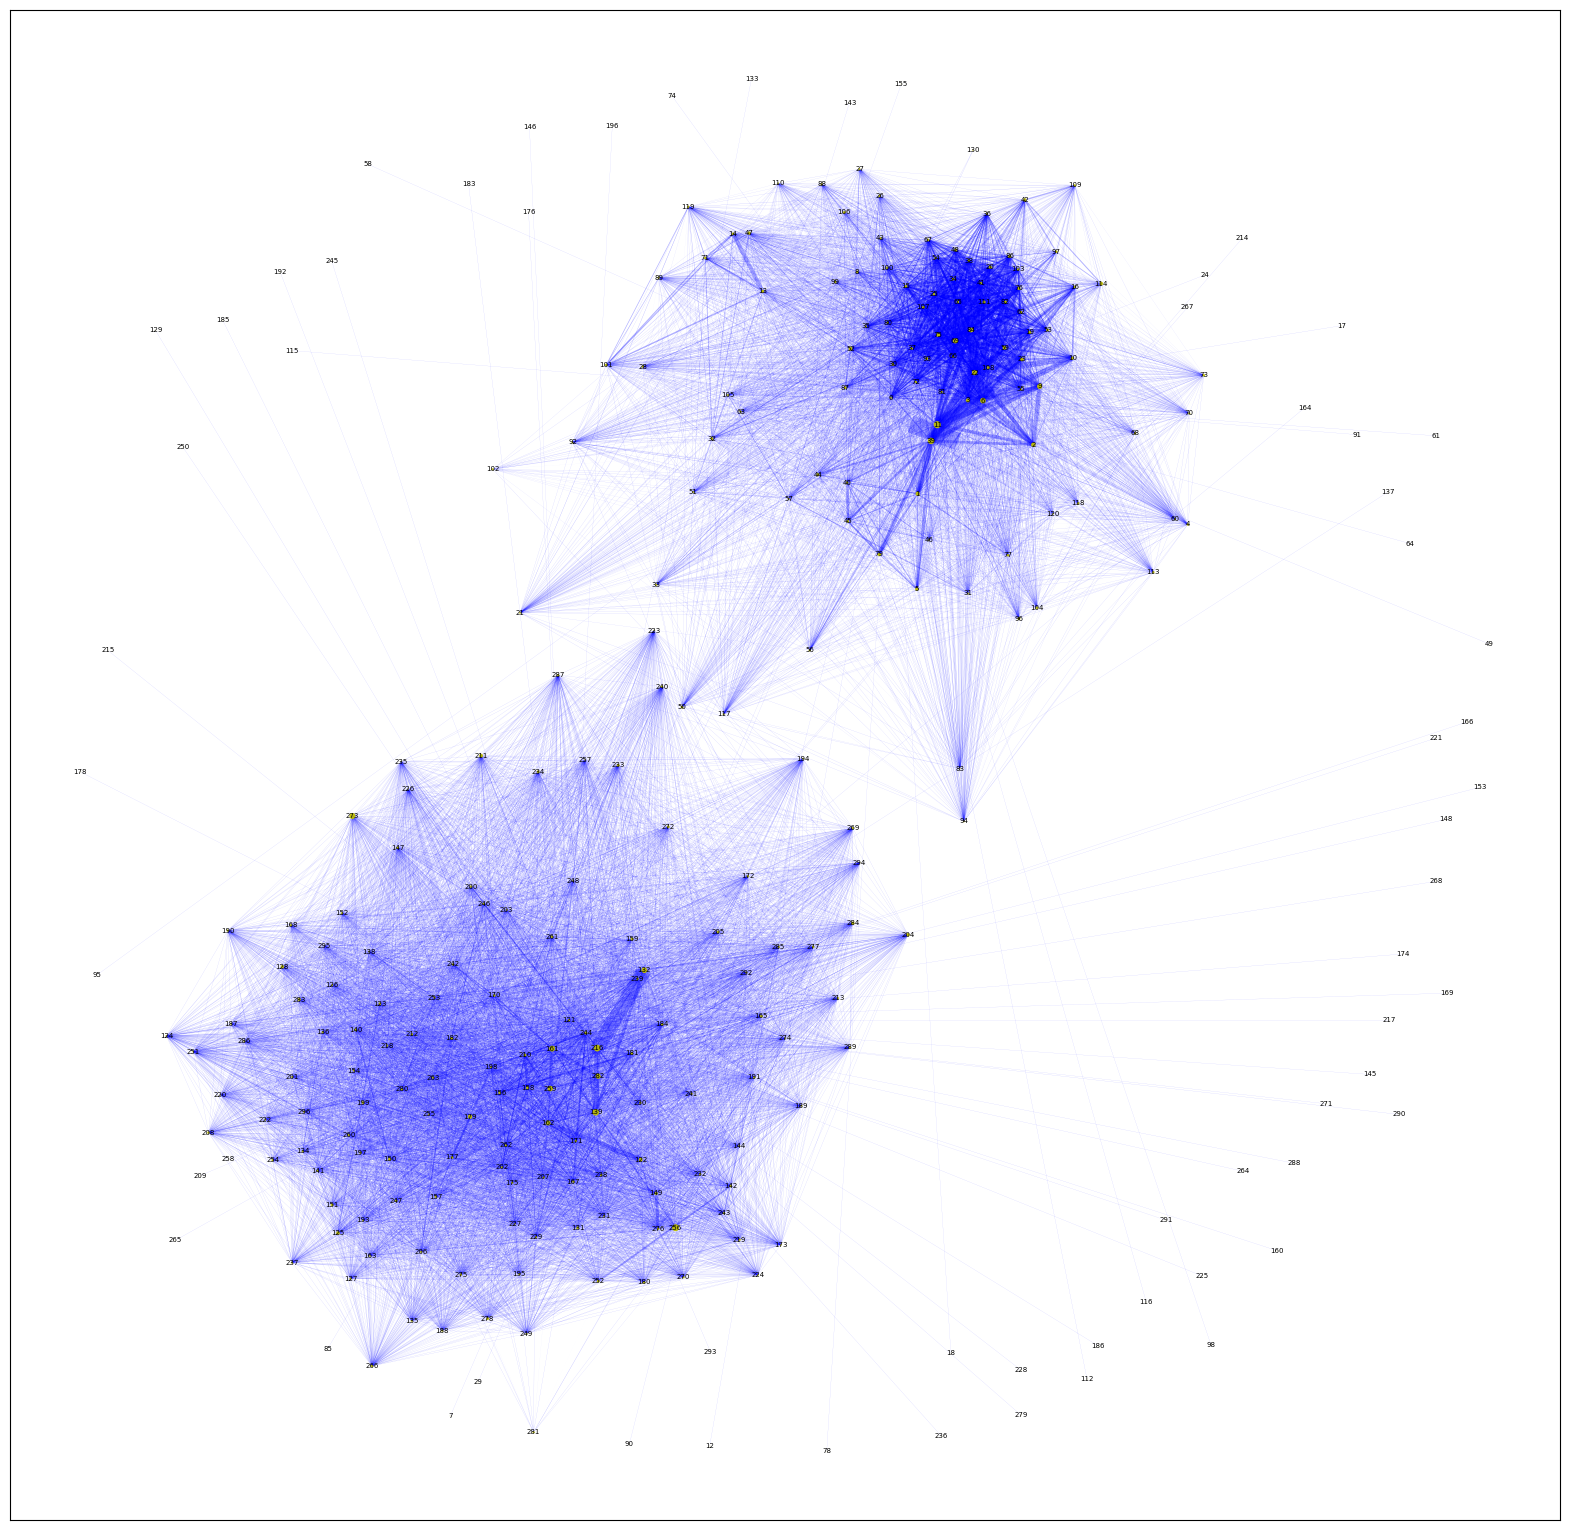

In [63]:
plot_graph(u1, 300, 1.5)

In [90]:
import plotly.graph_objects as go

def plot_graph_plotly(G, friends_out):
    pos=nx.spring_layout(G, k=1.5)
    #labels=list(G.vs['label'])
    N=len(G.nodes)
    E=[e for e in G.edges]# list of edges
    #layt=G.layout('kk') #kamada-kawai layout

    Xv=[pos[k][0] for k in friends_out]
    Yv=[pos[k][1] for k in friends_out]
    Xed=[]
    Yed=[]
    for edge in E:
        Xed+=[pos[edge[0]][0],pos[edge[1]][0], None]
        Yed+=[pos[edge[0]][1],pos[edge[1]][1], None]

    trace3=go.Scatter(x=Xed,
                y=Yed,
                mode='lines',
                line=dict(color='rgb(50,50,60)', width=0.1),
                hoverinfo='none'
                )
    trace4=go.Scatter(x=Xv,
                y=Yv,
                mode='markers',
                name='net',
                marker=dict(symbol='circle-dot',
                                size=5,
                                color='#6959CD',
                                line=dict(color='rgb(50,50,120)', width=0.5)
                                ),
                #text=labels,
                hoverinfo='text'
                )


    data1=[trace3, trace4]
    fig1=go.Figure(data=data1 )
    fig1.show()

In [91]:
# plot interactive graph (second variant)
friends_out_union_list = [*friends_out1[user1]['items'], *friends_out2[user2]['items']]

plot_graph_plotly(u1,friends_out_union_list)